[View in Colaboratory](https://colab.research.google.com/github/sungreong/Pymc3_bayseian-network/blob/master/Bayseian_Neural_Network_Using_Pymc3.ipynb)

[베이지안 뉴럴 네트워크 Reference](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/bayesian_neural_network_advi.ipynb)


In [1]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install patsy pandas

  Cloning https://github.com/pymc-devs/pymc3 to /tmp/pip-req-build-dzejp0w8
  Running setup.py bdist_wheel for pymc3 ... - \ | / - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-r1gye65v/wheels/a1/e3/71/a696f2af0dd40bccc0ce672d616d21cc9dd90dbdd3f03242f4
Successfully built pymc3


In [0]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [11]:

X,  Y  =  make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

print(X.shape)

(1000, 2)


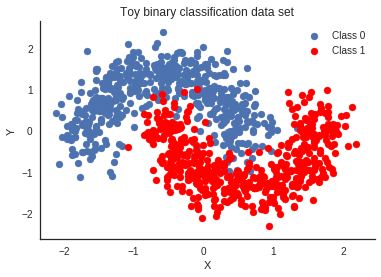

In [12]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

# Model 구체화 하기

네트워크는 꽤 심플하다 베이직 유닛은 펄셉트론 많은 뉴럴들을 쌓아서 만들것이다.

In [0]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network



In [0]:
## # Trick: Turn inputs and outputs into shared variables. 
## # It's still the same thing, but we can later change the values of the shared variable 
##  reference http://deeplearning.net/software/theano/library/compile/shared.html

ann_input = theano.shared(X_train)  ## These variables are meant to be created by registered shared constructors 
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

## 나쁘지 않다고 한다 노말 사전 분포가 가중치의 정규화를 도와줄 것이고 여기서는. bias 부분은 생략했다고 한다.


## Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like NUTS which works pretty well in this case, but as I already mentioned, 

**this will become very slow as we scale our model up to deeper architectures with more layers.**

## we will use the brand-new ADVI variational inference algorithm which was recently added to PyMC3, and updated to use the operator variational inference (OPVI) framework. 
* This is much faster and will scale better. 
* Note, that this is a mean-field approximation so we ignore correlations in the posterior. 민플드 가정을 통해 잠재변수들끼리는 독립이라는 가정을 깔고 시작한다.




In [0]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [24]:

%%time

with  neural_network :
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 182.73: 100%|██████████| 30000/30000 [00:41<00:00, 728.86it/s]


Finished [100%]: Average Loss = 182.65


CPU times: user 33 s, sys: 8.1 s, total: 41.1 s
Wall time: 1min 26s


In [37]:
%%time

with neural_network:
    advifit = pm.advi(n=30000)  ## advi 는 없어진 것 같다 old 형태라서 삭제된 것 같음

AttributeError: ignored

#### That's pretty good considering that NUTS is having a really hard time. Further below we make this even faster. 

### To make it really fly, we probably want to run the Neural Network on the GPU.

우리는 변분 근사로 부터 수비게 표본을 뽑을 수 있다 (MCMC는 아니지만 노말에서 뽑는 것과 같이)

In [0]:
trace = approx.sample(draws=5000)

Text(0.5,1,' new ADVI CONVERGE FASTER ')

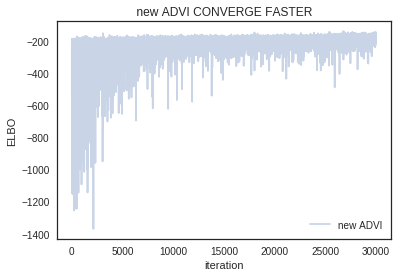

In [40]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
# plt.plot(advifit.elbo_vals, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration")
plt.title(" new ADVI CONVERGE FASTER ")

**POSTERIOR PREDICTIVE CHECK(PPC) **  를 사용하여 예측을 할 것이다.
 

1.   sample_ppc() 변분 추론으로부터 추출된 샘플인 사후분포로부터 새로운 데이터를 생성시킨다. 
2.   It is better to get the node directly and build theano graph using our approximation (approx.sample_node) , we get a lot of speed up



In [41]:

# We can get predicted probability from model# We can 
neural_network.out.distribution.p

sigmoid.0

In [46]:
# symbolic number of samples is supported, we build vectorized posterior on the fly
## create symbols
x =T.matrix("X")
print(x)

n= T.iscalar("n")
print(n)

# Do not forget test_values or set theano.config.compute_test_value = 'off'

x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100

# It is time to compile the function
# No updates are needed for Approximation random generator 
# Efficient vectorized form of sampling is used

_sample_proba = approx.sample_node(neural_network.out.distribution.p, 
                                   size=n,
                                   more_replacements={ann_input: x})

sample_proba = theano.function([x, n], _sample_proba)

X
n


In [0]:
## create benchmark functions

def production_step1():
    ann_input.set_value(X_test)
    ann_output.set_value(Y_test)
    with neural_network:
        ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5
    
def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

In [50]:
%timeit production_step1()

1 loop, best of 3: 307 ms per loop


In [51]:
%timeit production_step2()

10 loops, best of 3: 86.1 ms per loop


In [0]:
## generate prediction

pred = sample_proba(X_test, 500).mean(0) > 0.5



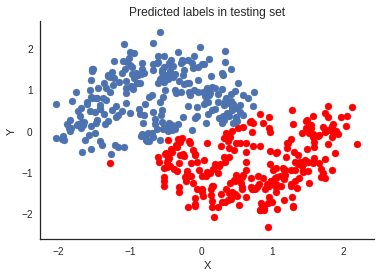

In [60]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [61]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))



Accuracy = 86.0%


In [0]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [0]:
ppc = sample_proba(grid_2d ,500)

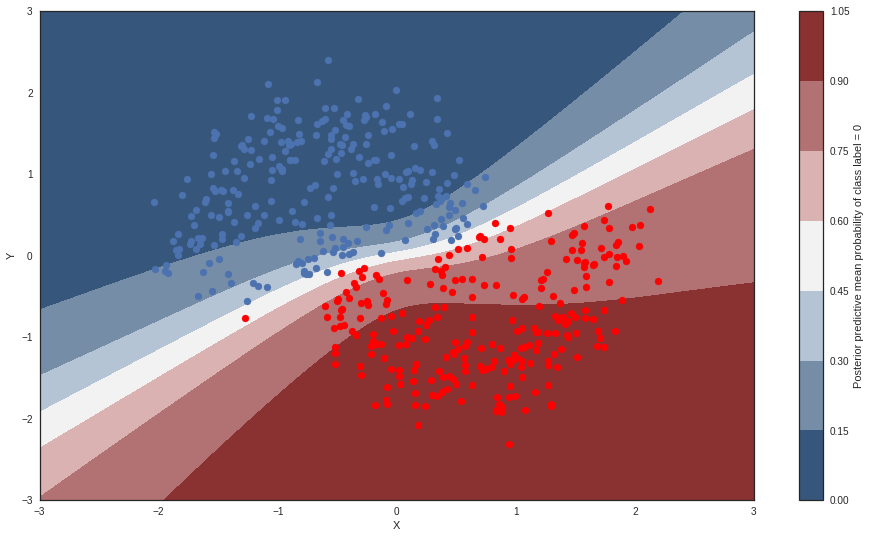

In [68]:

cmap  =  sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap) ### PPC.MEAN
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

## 예측된 값의 불확실성 
이제까지 한 것은 베이지안이 아닌 뉴럴넷이었다. 
**각각 클래스 레이블의 사후 예측치의 평균""은 MLE의 값과 값다

### 그러나 우리는 사후 예측치의 표준편차를 볼수 있다.  우리의 예측치에서 불확실성의 정도를 알 수 있다. 

이것은 decision boundary와 아주 유사하다. 예측할 레이블의 불확실성이 높은 것이다 

의료 산업에서 불확실성 예측은 굉장히 중요하다 우리는 정확도를 높이기 위해 높은 불확실성이 있는 지역에서 샘플을 학습시킬 수 있다.


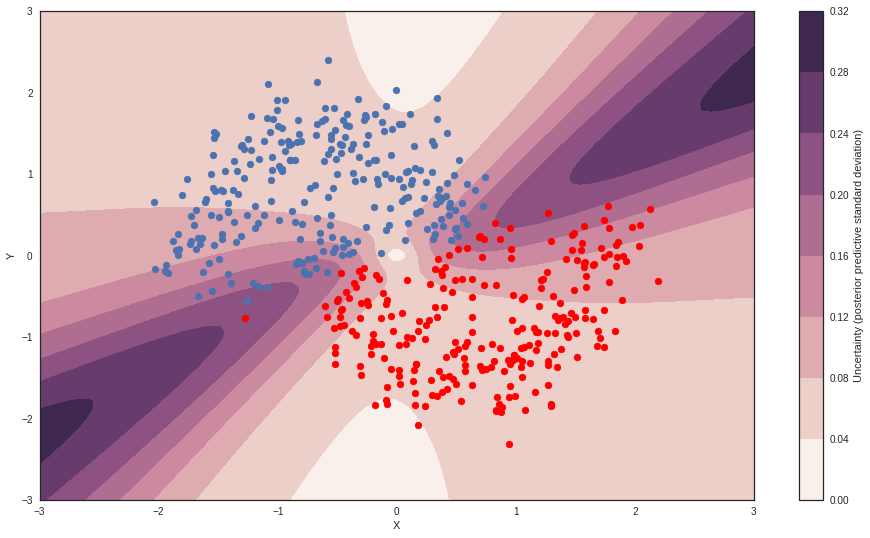

In [69]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)  #### PPC.STD()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## MINIBATCH ADV
I 
 우리는 아까 모든 데이터를 한번에 학습을 시켰다 이것은 좋지 않은 것이다  
 1. MINIBATCH를 사용하면 LOCAL MINIMA를 방지할 수 있다 . 
 2. 빠르게 수렴이 가능하다.
 
 수렴속도도 더 빠른 것을 확일 할 수 있다.

In [81]:
%%time

minibatch_x = pm.Minibatch(X_train , batch_size= 50)
minibatch_y = pm.Minibatch(Y_train, batch_size= 50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)

with neural_network_minibatch :
    approx = pm.fit(40000 , method=pm.ADVI())

Average Loss = 140.17: 100%|██████████| 40000/40000 [00:46<00:00, 868.23it/s]


Finished [100%]: Average Loss = 140.15


CPU times: user 32.3 s, sys: 10 s, total: 42.3 s
Wall time: 48.1 s


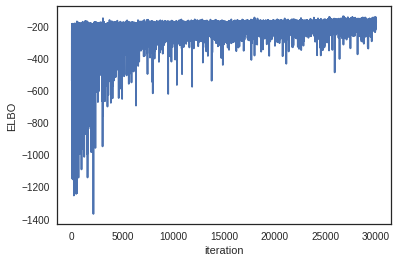

In [82]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

## 우리는 trace plot 을 통해 우리 weight의 불확실성을 알 수 있다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08d8bd2320>,
      dtype=object)

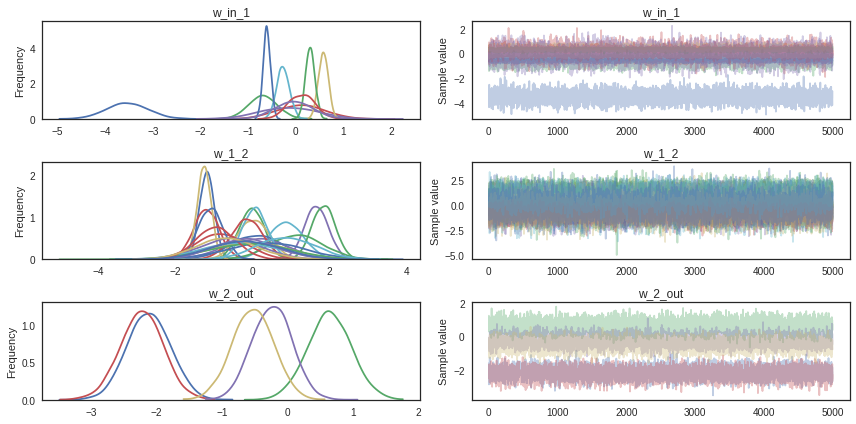

In [83]:
trace = approx.sample(draws=5000)
pm.traceplot(trace) 